In [11]:
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel
from darts.models import BlockRNNModel
from darts.models import TransformerModel
from darts.models import TCNModel
from darts import concatenate
from darts.metrics import mase

In [3]:
#Importing target times series
df_target = pd.read_csv("C:/Users/jbonhomme/OneDrive - EDF Renouvelables/Documents/GitHub/Darts_Project/Data/Transformed/B5_cycles_capacity.csv", encoding='utf-8')
df_target = df_target.rename(columns={'Parameter': 'Capacity',})
#df_target['Cycle'] = pd.to_datetime(df_target['Cycle'])

In [4]:
#Importing covariates
df_voltage = pd.read_csv("C:/Users/jbonhomme/OneDrive - EDF Renouvelables/Documents/GitHub/Darts_Project/Data/Transformed/time_series_voltage_table.csv", encoding='utf-8')
df_voltage = df_voltage.rename(columns={'index': 'Cycle',})
#df_cov['Cycle'] = pd.to_datetime(df_cov['Cycle'])

df_current = pd.read_csv("C:/Users/jbonhomme/OneDrive - EDF Renouvelables/Documents/GitHub/Darts_Project/Data/Transformed/time_series_current_table.csv", encoding='utf-8')
df_current = df_current.rename(columns={'index': 'Cycle',})

df_temp = pd.read_csv("C:/Users/jbonhomme/OneDrive - EDF Renouvelables/Documents/GitHub/Darts_Project/Data/Transformed/time_series_temp_table.csv", encoding='utf-8')
df_temp = df_temp.rename(columns={'index': 'Cycle',})

df_time = pd.read_csv("C:/Users/jbonhomme/OneDrive - EDF Renouvelables/Documents/GitHub/Darts_Project/Data/Transformed/time_series_time_table.csv", encoding='utf-8')
df_time = df_time.rename(columns={'index': 'Cycle',})

In [6]:
#Converting the target and covariate dataframe in a Darts time series format
target_series = TimeSeries.from_dataframe(df_target, 'Cycle', 'Capacity')

value_columns = df_voltage.columns.drop('Cycle').tolist()
cov_voltage_time_series = TimeSeries.from_dataframe(df_voltage, 'Cycle', value_columns)
value_columns = df_current.columns.drop('Cycle').tolist()
cov_current_time_series = TimeSeries.from_dataframe(df_current, 'Cycle', value_columns)
value_columns = df_temp.columns.drop('Cycle').tolist()
cov_temp_time_series = TimeSeries.from_dataframe(df_temp, 'Cycle', value_columns)
value_columns = df_time.columns.drop('Cycle').tolist()
cov_time_time_series = TimeSeries.from_dataframe(df_time, 'Cycle', value_columns)
past_covariates = concatenate([cov_voltage_time_series, cov_current_time_series, cov_temp_time_series, cov_time_time_series], axis=1)
# past_covariates = past_covariates[:train_size]

In [64]:
from darts.metrics import rmse

# We first set aside the first 50% as training series:
train_size = int(len(target_series) * 0.5)
train_dataset = target_series[:train_size]
test_dataset = target_series[train_size:]
# train_dataset = target_series

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 40% of the capacity series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=train_dataset, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=10,
                                          start_format='position', 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    target_series[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(train_dataset, backtest)))

In [65]:
brnn_voltage = BlockRNNModel(input_chunk_length=30, 
                                      output_chunk_length=5,
                                      model='RNN',
                                      n_rnn_layers=3,
                                      )

# brnn_voltage = TCNModel(input_chunk_length=30, 
#                                       output_chunk_length=10,
#                                       )

brnn_voltage.fit(train_dataset, 
                          past_covariates=past_covariates, 
                          epochs=500, 
                          verbose=True)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 40.4 K | train
6 | fc              | Sequential       | 130    | train
-------------------------------------------------------------
40.5 K    Trainable params
0         Non-trainable params
40.5 K    Total params
0.162     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=5)

In [ ]:
#  eval_model(brnn_voltage, 
#            past_covariates=[cov_voltage_time_series, cov_current_time_series, cov_temp_time_series, cov_time_time_series])

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Cycle'>

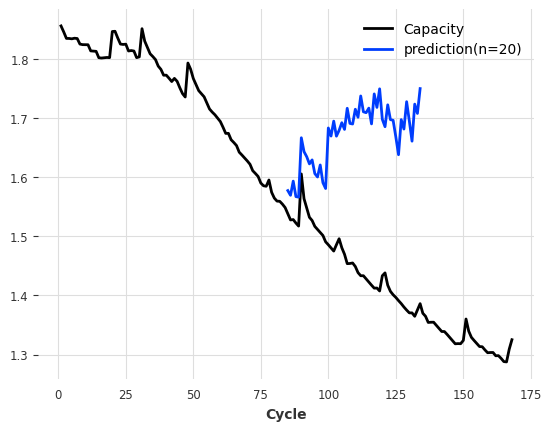

In [68]:
future = brnn_voltage.predict(n=50,
                       series=train_dataset,
                       past_covariates=past_covariates)
# mase_err = mase(target_series, future, train_dataset)
target_series.plot()
future.plot(label='prediction(n=20)')
# print('Prediction MASE = {}'.format(mase_err))

In [56]:
from darts.metrics import rmse

# We first set aside the first 50% as training series:
train_size = int(len(target_series) * 0.9)
train_dataset = target_series[:train_size]
test_dataset = target_series[train_size:]
# train_dataset = target_series

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 40% of the capacity series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=train_dataset, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=10,
                                          start_format='position', 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    target_series[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(train_dataset, backtest)))

In [59]:
brnn_voltage = BlockRNNModel(input_chunk_length=30, 
                                      output_chunk_length=10,
                                      model='RNN',
                                      n_rnn_layers=3,
                                      )

# brnn_voltage = TCNModel(input_chunk_length=30, 
#                                       output_chunk_length=10,
#                                       )

brnn_voltage.fit(train_dataset, 
                          past_covariates=past_covariates, 
                          epochs=500, 
                          verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 40.4 K | train
6 | fc              | Sequential       | 260    | train
-------------------------------------------------------------
40.7 K    Trainable params
0         Non-trainable params
40.7 K    Total params
0.163     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=10)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Cycle'>

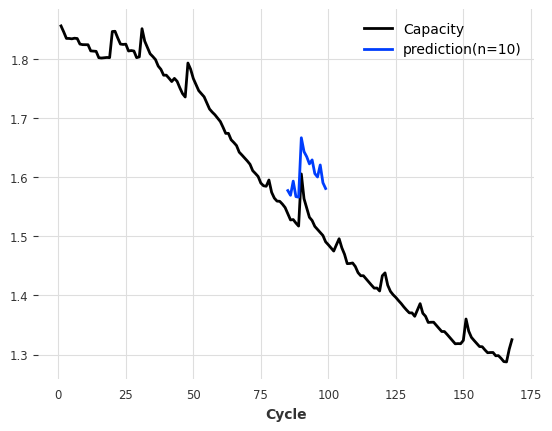

In [69]:
future = brnn_voltage.predict(n=15,
                       series=train_dataset,
                       past_covariates=past_covariates)
# mase_err = mase(target_series, future, train_dataset)
target_series.plot()
future.plot(label='prediction(n=10)')
# print('Prediction MASE = {}'.format(mase_err))